## Run once after (re)starting the kernel

<div class="alert alert-block alert-success" align="left">
  <b>Why this cell?</b><br/>
  It initializes the workspace for the current AOI—sets <code>PROJECT_ROOT</code>/<code>AOI</code>, adds <code>src/</code> to <code>sys.path</code>, clears the import cache, and loads <code>config.py</code> so <code>PATHS</code>/<code>PARAMS</code> are available to all steps.
  <br/><br/>
  <b>When to run it</b>
  <ul>
    <li>After a kernel restart (once).</li>
    <li>After changing <code>AOI_VALUE</code> or editing <code>config.py</code> (paths/parameters/templates).</li>
    <li>After moving the project folder.</li>
  </ul>
</code>.
</div>


In [15]:
# Bootstrap imports for package-style repo
import os, sys, importlib
from pathlib import Path

# >>>> EDIT THESE TWO ONLY <<<<
PROJECT_ROOT = Path("/mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis")
AOI_VALUE = "huambo"  # e.g., "benguela", "huambo", "bei", "moxico", "moxicoleste"

# Environment for the codebase
os.environ["PROJECT_ROOT"] = str(PROJECT_ROOT)
os.environ["AOI"] = AOI_VALUE

# Make sure we can import src/config.py, src/step_*.py, etc.
SRC = PROJECT_ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# Optional: import config once so PATHS etc. are ready
import config
importlib.reload(config)  # ensure it sees the AOI env
from config import PATHS

print("PROJECT_ROOT:", PROJECT_ROOT)
print("AOI         :", AOI_VALUE)
print("PATHS.OUT_T :", PATHS.OUT_T)


PROJECT_ROOT: /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis
AOI         : huambo
PATHS.OUT_T : /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables


## Table S1 – priority clusters by province

In [2]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

# We already have PATHS from the bootstrap cell
OUT_T = PATHS.OUT_T

print("Tables dir:", OUT_T.resolve())

# Auto-detect AOIs that have cluster tables
cluster_files = sorted(OUT_T.glob("*_priority_clusters.csv"))
if not cluster_files:
    raise SystemExit("No *_priority_clusters.csv files found in outputs/tables")

aois = sorted({f.stem.replace("_priority_clusters", "") for f in cluster_files})
print("Detected AOIs:", ", ".join(aois))


def infer_totals_from_kpi_csv(aoi: str) -> tuple[float, float]:
    """
    Infer total population and total cropland km² in the AOI from
    the kpis_isochrones table:

        pop_pct = pop_within / pop_total * 100
        cropland_pct = cropland_km2_within / cropland_km2_total * 100

    We invert this relationship using one valid row.
    """
    path = OUT_T / f"{aoi}_kpis_isochrones.csv"
    if not path.exists():
        print(f"[WARN] KPI CSV missing for AOI={aoi}: {path.name}")
        return np.nan, np.nan

    kpis = pd.read_csv(path)

    pop_total = np.nan
    crop_total = np.nan

    if "pop_within" in kpis.columns and "pop_pct" in kpis.columns:
        m = kpis["pop_pct"].between(0.001, 100.0)
        if m.any():
            r = kpis.loc[m].iloc[0]
            pop_total = float(r["pop_within"] * 100.0 / r["pop_pct"])

    if "cropland_km2" in kpis.columns and "cropland_pct" in kpis.columns:
        m2 = kpis["cropland_pct"].between(0.001, 100.0)
        if m2.any():
            r2 = kpis.loc[m2].iloc[0]
            crop_total = float(r2["cropland_km2"] * 100.0 / r2["cropland_pct"])

    return pop_total, crop_total


rows = []

for aoi in aois:
    print(f"\n=== AOI: {aoi} ===")
    clusters_path = OUT_T / f"{aoi}_priority_clusters.csv"

    if not clusters_path.exists():
        print(f"[SKIP] No clusters table for {aoi}")
        continue

    clusters = pd.read_csv(clusters_path)

    # Numerators from Step 11
    n_clusters = len(clusters)
    priority_area_km2 = float(clusters["area_km2"].sum())
    pop_in_priority = float(clusters["pop"].sum())
    cropland_in_priority_km2 = float(clusters["cropland_km2"].sum())

    # Denominators from Step 02
    pop_total, crop_total = infer_totals_from_kpi_csv(aoi)

    pop_pct_in_priority = (
        pop_in_priority / pop_total * 100.0 if pop_total and pop_total > 0 else np.nan
    )
    crop_pct_in_priority = (
        cropland_in_priority_km2 / crop_total * 100.0 if crop_total and crop_total > 0 else np.nan
    )

    # Extra diagnostics: densities in the priority mask
    pop_density_priority = (
        pop_in_priority / priority_area_km2 if priority_area_km2 > 0 else np.nan
    )
    crop_density_priority = (
        cropland_in_priority_km2 / priority_area_km2 if priority_area_km2 > 0 else np.nan
    )

    rows.append(
        {
            "aoi": aoi,
            "n_clusters": n_clusters,
            "priority_area_km2": priority_area_km2,
            "pop_in_priority": pop_in_priority,
            "pop_total": pop_total,
            "pop_pct_in_priority": pop_pct_in_priority,
            "cropland_km2_in_priority": cropland_in_priority_km2,
            "cropland_km2_total": crop_total,
            "cropland_pct_in_priority": crop_pct_in_priority,
            "pop_density_in_priority_per_km2": pop_density_priority,
            "cropland_density_in_priority_km2_per_km2": crop_density_priority,
        }
    )

table_s1 = pd.DataFrame(rows).sort_values("aoi")

# Round for presentation
table_s1_rounded = table_s1.copy()
for col in [
    "priority_area_km2",
    "pop_in_priority",
    "pop_total",
    "pop_pct_in_priority",
    "cropland_km2_in_priority",
    "cropland_km2_total",
    "cropland_pct_in_priority",
    "pop_density_in_priority_per_km2",
    "cropland_density_in_priority_km2_per_km2",
]:
    if col in table_s1_rounded:
        table_s1_rounded[col] = table_s1_rounded[col].round(2)

# Save & display
out_csv = OUT_T / "summary_table_s1_priority_clusters.csv"
table_s1_rounded.to_csv(out_csv, index=False)
print("\nSaved Table S1 CSV →", out_csv)

table_s1_rounded


Tables dir: /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables
Detected AOIs: huambo

=== AOI: huambo ===

Saved Table S1 CSV → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables/summary_table_s1_priority_clusters.csv


,aoi,n_clusters,priority_area_km2,pop_in_priority,pop_total,pop_pct_in_priority,cropland_km2_in_priority,cropland_km2_total,cropland_pct_in_priority,pop_density_in_priority_per_km2,cropland_density_in_priority_km2_per_km2
0,huambo,2,52.86,31776.0,2997196.75,1.06,34.72,10156.91,0.34,601.14,0.66


## Figure S1 – map of priority clusters for the current AOI

Current AOI: huambo


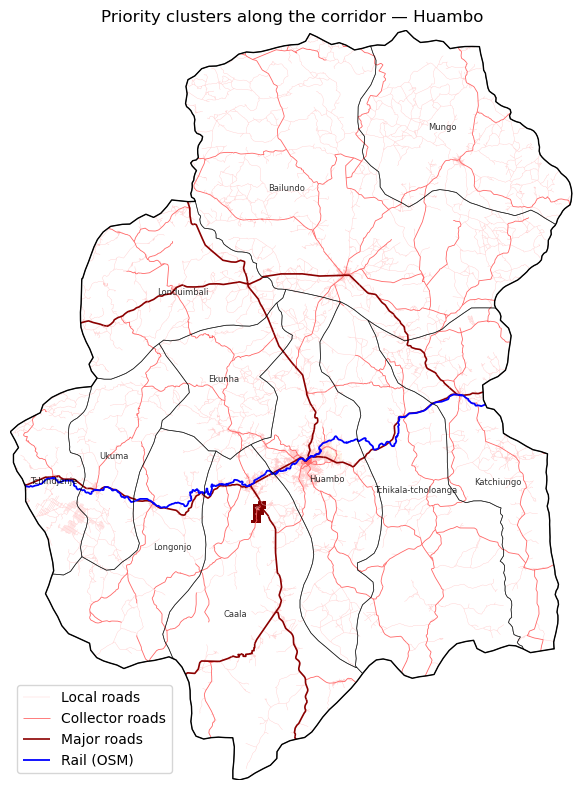

Saved Figure S1 map → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/figs/fig_s1_priority_clusters_huambo_adm2_roads.png


In [6]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show

from config import PATHS, PRIORITY_CLUSTERS_TIF

# Current AOI is set via AOI_VALUE + os.environ["AOI"]
aoi = os.environ.get("AOI", "unknown")
print("Current AOI:", aoi)

cluster_raster = PRIORITY_CLUSTERS_TIF
if not cluster_raster.exists():
    raise FileNotFoundError(f"Cluster raster missing: {cluster_raster}")

# -------------------------------------------------------------------
# Read cluster raster
# -------------------------------------------------------------------
with rasterio.open(cluster_raster) as src:
    arr = src.read(1)
    transform = src.transform
    crs = src.crs

    # Treat zeros & NaNs as background
    arr = np.where(np.isfinite(arr) & (arr > 0), arr, np.nan)

# -------------------------------------------------------------------
# Read vector layers: ADM1, ADM2, rail, roads
# -------------------------------------------------------------------
adm1 = gpd.read_file(PATHS.BND_ADM1).to_crs(crs)
adm2 = gpd.read_file(PATHS.BND_ADM2).to_crs(crs)
rail = gpd.read_file(PATHS.RAIL).to_crs(crs)
roads = gpd.read_file(PATHS.ROADS).to_crs(crs)

# -------------------------------------------------------------------
# Classify roads into Major / Collector / Local by fclass
# -------------------------------------------------------------------
if "fclass" in roads.columns:
    f = roads["fclass"].str.lower().fillna("")

    major_classes = {
        "motorway", "motorway_link",
        "trunk", "trunk_link",
        "primary", "primary_link",
    }
    collector_classes = {
        "secondary", "secondary_link",
        "tertiary", "tertiary_link",
    }

    def classify_road(val: str) -> str:
        if val in major_classes:
            return "major"
        if val in collector_classes:
            return "collector"
        return "local"

    roads["road_class"] = f.apply(classify_road)

    roads_major = roads[roads["road_class"] == "major"]
    roads_collector = roads[roads["road_class"] == "collector"]
    roads_local = roads[roads["road_class"] == "local"]
else:
    print("[WARN] 'fclass' column missing in roads; plotting all as 'local'.")
    roads["road_class"] = "local"
    roads_major = roads.iloc[0:0].copy()
    roads_collector = roads.iloc[0:0].copy()
    roads_local = roads

# -------------------------------------------------------------------
# Prepare Admin2 label points (use representative_point to stay inside polygons)
# -------------------------------------------------------------------
if "NAM_2" in adm2.columns:
    adm2["label_point"] = adm2.geometry.representative_point()
else:
    print("[WARN] 'NAM_2' column missing in ADM2; no labels will be drawn.")

# -------------------------------------------------------------------
# Plot
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 8))

# Priority clusters raster (background)
show(
    arr,
    transform=transform,
    ax=ax,
    cmap="OrRd",
    interpolation="nearest",
    zorder=1,
)

# Roads (drawn below boundaries; major on top of other roads)
if not roads_local.empty:
    roads_local.plot(
        ax=ax, linewidth=0.3, color="#ffcccc", label="Local roads", zorder=2
    )
if not roads_collector.empty:
    roads_collector.plot(
        ax=ax, linewidth=0.6, color="#ff6666", label="Collector roads", zorder=3
    )
if not roads_major.empty:
    roads_major.plot(
        ax=ax, linewidth=1.2, color="#8b0000", label="Major roads", zorder=4
    )

# Rail (distinct blue)
rail.plot(ax=ax, linewidth=1.3, color="blue", label="Rail (OSM)", zorder=5)

# Admin boundaries
adm2.boundary.plot(ax=ax, linewidth=0.5, color="black", alpha=0.7, zorder=6)
adm1.boundary.plot(ax=ax, linewidth=1.0, color="black", zorder=7)

# Admin2 labels
if "NAM_2" in adm2.columns:
    for _, row in adm2.iterrows():
        x, y = row["label_point"].x, row["label_point"].y
        name = str(row["NAM_2"])
        ax.text(
            x,
            y,
            name,
            fontsize=6,
            ha="center",
            va="center",
            color="black",
            alpha=0.8,
            zorder=8,
        )

ax.set_title(f"Priority clusters along the corridor — {aoi.capitalize()}")
ax.set_axis_off()

# Clean legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="lower left")

fig.tight_layout()

# Show in notebook
plt.show()

# Save to file
out_fig_dir = PATHS.OUT_F
out_fig_dir.mkdir(parents=True, exist_ok=True)
out_png = out_fig_dir / f"{aoi}_fig_s1_priority_clusters_adm2_roads.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
print("Saved Figure S1 map →", out_png)


## Table S2 – Top municipalities by composite score (corridor-wide)

In [13]:
from pathlib import Path
import numpy as np
import pandas as pd

from config import PATHS

OUT_T = PATHS.OUT_T

# Find all AOIs that have Step 09 outputs
muni_files = sorted(OUT_T.glob("*_priority_muni_rank.csv"))
if not muni_files:
    raise SystemExit("No *_priority_muni_rank.csv files found in outputs/tables")

aois = sorted({f.stem.replace("_priority_muni_rank", "") for f in muni_files})
print("Detected AOIs:", ", ".join(aois))

TOP_N = 5  # how many top municipalities per AOI to include

rows = []

for aoi in aois:
    path = OUT_T / f"{aoi}_priority_muni_rank.csv"
    if not path.exists():
        print(f"[SKIP] Missing {path.name}")
        continue

    df = pd.read_csv(path)
    print(f"\n=== AOI: {aoi} | municipalities={len(df)} ===")

    # Expect at minimum these columns
    required = ["area_km2", "score"]
    for col in required:
        if col not in df.columns:
            raise ValueError(f"{path.name} missing required column {col!r}")

    # pct_priority may or may not exist
    if "pct_priority" not in df.columns:
        df["pct_priority"] = 0.0

    # Interpret pct_priority as fraction; if values look like 0–100, rescale
    max_pp = df["pct_priority"].max()
    if max_pp > 1.5:  # likely in percentage units
        frac_priority = df["pct_priority"] / 100.0
    else:
        frac_priority = df["pct_priority"]

    # Priority area in each municipality (km²)
    df["priority_area_km2"] = df["area_km2"] * frac_priority

    total_priority_area = df["priority_area_km2"].sum()
    if total_priority_area > 0:
        df["share_province_priority_pct"] = (
            df["priority_area_km2"] / total_priority_area * 100.0
        )
    else:
        df["share_province_priority_pct"] = np.nan

    # ---- Alias travel time column to "mean_travel_time_min" ----
    if "avg_hours_to_market_financial" in df.columns:
        # Values are already in minutes (Step 06 converts hours → minutes)
        df["mean_travel_time_min"] = df["avg_hours_to_market_financial"]

    # Take top N by composite score
    top = df.sort_values("score", ascending=False).head(TOP_N).copy()
    top.insert(0, "AOI", aoi)  # Province tag

    rows.append(top)

if not rows:
    raise SystemExit("No municipalities collected for Table S2.")

all_top = pd.concat(rows, ignore_index=True)

# Columns to report in S2 (only keep if present)
cols_for_s2 = [
    "AOI",           # Province (AOI)
    "ADM2CD_c", "NAM_1", "NAM_2",
    "score",
]

for c in [
    "poverty_rural",
    "food_insec_scale",
    "mean_travel_time_min",        # <- new, clearer name
    "pct_electrified",
    "share_province_priority_pct",
]:
    if c in all_top.columns:
        cols_for_s2.append(c)

table_s2 = all_top[cols_for_s2].copy()

# Round for readability
round_cols = [
    "score",
    "poverty_rural",
    "food_insec_scale",
    "mean_travel_time_min",
    "pct_electrified",
    "share_province_priority_pct",
]
for c in round_cols:
    if c in table_s2.columns:
        table_s2[c] = table_s2[c].round(3)

out_csv = OUT_T / "summary_table_s2_top_municipalities.csv"
table_s2.to_csv(out_csv, index=False)
print("\nSaved Table S2 CSV →", out_csv)

# Preview
table_s2


Detected AOIs: huambo

=== AOI: huambo | municipalities=11 ===

Saved Table S2 CSV → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables/summary_table_s2_top_municipalities.csv


,AOI,ADM2CD_c,NAM_1,NAM_2,score,poverty_rural,food_insec_scale,mean_travel_time_min,pct_electrified,share_province_priority_pct
0,huambo,AGO009007,Huambo,Longonjo,0.549,0.616,0.730,286.190,0.005,0.00
1,huambo,AGO009002,Huambo,Caala,0.509,0.635,0.663,71.650,0.024,49.16
2,huambo,AGO009008,Huambo,Mungo,0.469,0.673,0.692,182.182,0.004,0.00
3,huambo,AGO009006,Huambo,Londuimbali,0.463,0.650,0.644,351.733,0.009,0.00
4,huambo,AGO009003,Huambo,Ekunha,0.394,0.683,0.685,61.163,0.006,0.00


## Figure S2 – Priority score vs rural poverty (scatter, all municipalities)

Total municipalities: 11
With score & rural poverty: 11


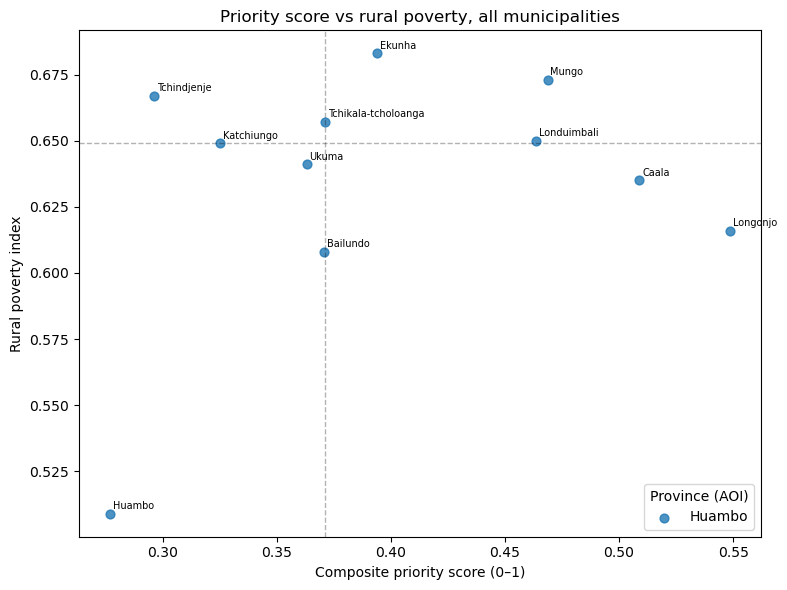

Saved Figure S2 → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/figs/fig_s2_priority_vs_poverty_scatter.png


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from config import PATHS

OUT_T = PATHS.OUT_T

muni_files = sorted(OUT_T.glob("*_priority_muni_rank.csv"))
if not muni_files:
    raise SystemExit("No *_priority_muni_rank.csv files found.")

rows = []
for f in muni_files:
    aoi = f.stem.replace("_priority_muni_rank", "")
    df = pd.read_csv(f)
    df["AOI"] = aoi
    rows.append(df)

all_muni = pd.concat(rows, ignore_index=True)
print("Total municipalities:", len(all_muni))

# Keep only those with both score and rural poverty
mask = all_muni["score"].notna() & all_muni["poverty_rural"].notna()
data = all_muni.loc[mask].copy()
print("With score & rural poverty:", len(data))

if data.empty:
    raise SystemExit("No municipalities with both score and poverty_rural.")

# -------------------------------------------------------------------
# Scatter: score vs rural poverty, colored by AOI
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

for aoi, sub in data.groupby("AOI"):
    ax.scatter(
        sub["score"],
        sub["poverty_rural"],
        s=40,
        alpha=0.8,
        label=aoi.capitalize(),
    )

ax.set_xlabel("Composite priority score (0–1)")
ax.set_ylabel("Rural poverty index")
ax.set_title("Priority score vs rural poverty, all municipalities")

# Median reference lines (implicit quadrants)
x_med = data["score"].median()
y_med = data["poverty_rural"].median()
ax.axvline(x_med, color="k", linestyle="--", linewidth=1, alpha=0.3)
ax.axhline(y_med, color="k", linestyle="--", linewidth=1, alpha=0.3)

# -------------------------------------------------------------------
# Label *every* point with its Admin2 name (or code)
# -------------------------------------------------------------------
for _, row in data.iterrows():
    name = str(row.get("NAM_2", row.get("ADM2CD_c")))
    ax.annotate(
        name,
        xy=(row["score"], row["poverty_rural"]),
        xytext=(2, 2),           # small offset in points
        textcoords="offset points",
        fontsize=7,
        ha="left",
        va="bottom",
    )

ax.legend(title="Province (AOI)", loc="lower right")
fig.tight_layout()
plt.show()

out_fig = PATHS.OUT_F / f"{AOI}_fig_s2_priority_vs_poverty_scatter.png"
fig.savefig(out_fig, dpi=300, bbox_inches="tight")
print("Saved Figure S2 →", out_fig)


In [9]:
import numpy as np
import pandas as pd
from config import PATHS

OUT_T = PATHS.OUT_T

# -------------------------------------------------------------------
# 1) Load all municipality tables
# -------------------------------------------------------------------
muni_files = sorted(OUT_T.glob("*_priority_muni_rank.csv"))
if not muni_files:
    raise SystemExit("No *_priority_muni_rank.csv files found.")

rows = []
for f in muni_files:
    aoi = f.stem.replace("_priority_muni_rank", "")
    df = pd.read_csv(f)
    df["AOI"] = aoi
    rows.append(df)

all_muni = pd.concat(rows, ignore_index=True)
print("Total municipalities:", len(all_muni))

# Keep only those with both score and rural poverty
mask = all_muni["score"].notna() & all_muni["poverty_rural"].notna()
data = all_muni.loc[mask].copy()
print("With score & rural poverty:", len(data))

if data.empty:
    raise SystemExit("No municipalities with both score and poverty_rural.")

# -------------------------------------------------------------------
# 2) Estimate rural poor counts if possible
# -------------------------------------------------------------------
pop_col = None
if "pop_rural" in data.columns:
    pop_col = "pop_rural"
elif "pop_total" in data.columns:
    pop_col = "pop_total"

rural_poor_col = None

if pop_col is not None:
    # Try to interpret poverty_rural as a rate (0–1 or %)
    max_pov = data["poverty_rural"].max()
    pov_rate = None

    if max_pov <= 1.5:
        # Assume already 0–1
        pov_rate = data["poverty_rural"].clip(lower=0, upper=1)
    elif max_pov <= 100.0:
        # Assume 0–100%, convert to 0–1
        pov_rate = (data["poverty_rural"] / 100.0).clip(lower=0, upper=1)
    else:
        print(
            "[WARN] poverty_rural looks like an index (max > 100); "
            "will NOT compute rural poor counts."
        )

    if pov_rate is not None:
        data["rural_poor_est"] = data[pop_col] * pov_rate
        rural_poor_col = "rural_poor_est"
        print(f"Using {pop_col!r} and poverty_rural to estimate rural poor counts.")
else:
    print("[WARN] No pop_rural or pop_total column found; "
          "will only report municipality counts per quadrant.")

# -------------------------------------------------------------------
# 3) Define quadrants using corridor-wide medians
# -------------------------------------------------------------------
x_med = float(data["score"].median())
y_med = float(data["poverty_rural"].median())

def quadrant_label(row) -> str:
    hi_score = row["score"] >= x_med
    hi_pov = row["poverty_rural"] >= y_med
    if hi_score and hi_pov:
        return "High score & high poverty"
    if hi_score and not hi_pov:
        return "High score & lower poverty"
    if not hi_score and hi_pov:
        return "Lower score & high poverty"
    return "Lower score & lower poverty"

data["quadrant"] = data.apply(quadrant_label, axis=1)

# -------------------------------------------------------------------
# 4) Aggregate stats per quadrant
# -------------------------------------------------------------------
group_cols = ["quadrant"]
agg_dict = {"ADM2CD_c": "count"}  # muni count
if rural_poor_col is not None:
    agg_dict[rural_poor_col] = "sum"

quad_stats = data.groupby(group_cols).agg(agg_dict).reset_index()
quad_stats = quad_stats.rename(columns={"ADM2CD_c": "n_munis"})

if rural_poor_col is not None:
    total_rural_poor = quad_stats[rural_poor_col].sum()
    quad_stats["share_corridor_rural_poor_pct"] = np.where(
        total_rural_poor > 0,
        quad_stats[rural_poor_col] / total_rural_poor * 100.0,
        np.nan,
    )
else:
    total_rural_poor = None
    quad_stats["share_corridor_rural_poor_pct"] = np.nan

# Sort in a meaningful order
order = [
    "High score & high poverty",
    "High score & lower poverty",
    "Lower score & high poverty",
    "Lower score & lower poverty",
]
quad_stats["order"] = quad_stats["quadrant"].apply(
    lambda q: order.index(q) if q in order else len(order)
)
quad_stats = quad_stats.sort_values("order").drop(columns="order")

print("\nQuadrant stats:")
quad_stats


Total municipalities: 11
With score & rural poverty: 11
Using 'pop_total' and poverty_rural to estimate rural poor counts.

Quadrant stats:


,quadrant,n_munis,rural_poor_est,share_corridor_rural_poor_pct
0,High score & high poverty,4,434986.119697,24.450089
1,High score & lower poverty,2,342829.078235,19.270044
2,Lower score & high poverty,2,146194.196262,8.217414
3,Lower score & lower poverty,3,855068.445733,48.062453


In [10]:
total_munis = len(data)

# Helper to get a row safely
def _row_for(label: str):
    row = quad_stats.loc[quad_stats["quadrant"] == label]
    return row.iloc[0] if not row.empty else None

hi_hi = _row_for("High score & high poverty")
lo_hi = _row_for("Lower score & high poverty")

lines = []

if hi_hi is not None:
    n_hi_hi = int(hi_hi["n_munis"])
    pct_hi_hi = n_hi_hi / total_munis * 100.0

    if rural_poor_col is not None:
        share_poor_hi_hi = hi_hi["share_corridor_rural_poor_pct"]
        lines.append(
            f"- About {n_hi_hi} of {total_munis} municipalities "
            f"({pct_hi_hi:.1f}%) fall in the **high score & high poverty** quadrant, "
            f"representing roughly {share_poor_hi_hi:.1f}% of the estimated rural poor "
            "covered by the dataset."
        )
    else:
        lines.append(
            f"- About {n_hi_hi} of {total_munis} municipalities "
            f"({pct_hi_hi:.1f}%) fall in the **high score & high poverty** quadrant."
        )

if lo_hi is not None:
    n_lo_hi = int(lo_hi["n_munis"])
    pct_lo_hi = n_lo_hi / total_munis * 100.0

    if rural_poor_col is not None:
        share_poor_lo_hi = lo_hi["share_corridor_rural_poor_pct"]
        lines.append(
            f"- Around {n_lo_hi} municipalities ({pct_lo_hi:.1f}%) sit in the "
            f"**lower score & high poverty** quadrant, accounting for about "
            f"{share_poor_lo_hi:.1f}% of the estimated rural poor — these are "
            "potentially under-prioritized areas."
        )
    else:
        lines.append(
            f"- Around {n_lo_hi} municipalities ({pct_lo_hi:.1f}%) sit in the "
            "**lower score & high poverty** quadrant — potentially under-prioritized areas."
        )

print("\nSuggested markdown bullet points for the Summary page:\n")
print("```markdown")
for line in lines:
    print(line)
print("```")



Suggested markdown bullet points for the Summary page:

```markdown
- About 4 of 11 municipalities (36.4%) fall in the **high score & high poverty** quadrant, representing roughly 24.5% of the estimated rural poor covered by the dataset.
- Around 2 municipalities (18.2%) sit in the **lower score & high poverty** quadrant, accounting for about 8.2% of the estimated rural poor — these are potentially under-prioritized areas.
```


## Table S3 (top sites by 60-minute catchment)

In [18]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray as rxr
from pathlib import Path

from config import PATHS, AOI, CATCHMENTS_KPI_CSV  # <-- note CATCHMENTS_KPI_CSV from config


def build_table_s3(top_n: int = 10, thresh_min: int = 60) -> pd.DataFrame:
    """
    Build Table S3 for the current AOI:

    - Uses Step 12 KPI summary: {AOI}_catchments_kpis.csv
    - Filters to a single threshold (default: 60 minutes)
    - Ranks sites by population within that threshold
    - Joins optional site metadata from PATHS.SITES
    - Computes each site's share of the provincial population
      (based on PATHS.POP, the 1-km population raster).

    Returns
    -------
    DataFrame with columns ready to drop into Table S3.
    """
    csv_path = CATCHMENTS_KPI_CSV  # from config, not PATHS
    if not Path(csv_path).exists():
        raise FileNotFoundError(f"Catchment KPI table not found: {csv_path}")

    df = pd.read_csv(csv_path)
    if "thresh_min" not in df.columns or "pop" not in df.columns:
        raise ValueError(f"{csv_path} is missing 'thresh_min' or 'pop' columns")

    df = df[df["thresh_min"] == thresh_min].copy()
    if df.empty:
        raise ValueError(f"No records in {csv_path} for thresh_min={thresh_min}")

    # Rank sites by population at this threshold
    df = df.sort_values("pop", ascending=False).reset_index(drop=True)
    df["rank_pop_60min"] = np.arange(1, len(df) + 1)

    # Optional: join site metadata from the AOI sites shapefile
    site_name_col = None
    site_type_col = None

    try:
        sites = gpd.read_file(PATHS.SITES).reset_index().rename(columns={"index": "site_index"})
        # Align with Step 12 convention (site_index = 1..N)
        sites["site_index"] = sites["site_index"] + 1

        # Heuristic: choose best-guess name and type columns if they exist
        for cand in ["name", "NAME", "site_name", "Site", "SITE"]:
            if cand in sites.columns:
                site_name_col = cand
                break
        for cand in ["site_type", "SiteType", "TYPE", "type", "category", "Category"]:
            if cand in sites.columns:
                site_type_col = cand
                break

        meta_cols = ["site_index"]
        if site_name_col:
            meta_cols.append(site_name_col)
        if site_type_col:
            meta_cols.append(site_type_col)

        sites_meta = sites[meta_cols].copy()
        df = df.merge(sites_meta, on="site_index", how="left")
    except Exception as e:
        print(f"[WARN] Could not join site metadata from {PATHS.SITES}: {e}")
        df["site_name"] = np.nan
        df["site_type"] = np.nan
        site_name_col = "site_name"
        site_type_col = "site_type"

    # Provincial population denominator (from 1-km pop raster)
    pop_da = rxr.open_rasterio(PATHS.POP, masked=True).squeeze()
    total_pop = float(pop_da.sum().item())

    # Site ID: prefer human-readable name if available, else "site_<index>"
    if site_name_col and site_name_col in df.columns:
        df["Site ID"] = df[site_name_col].fillna(df["site_index"].map(lambda i: f"site_{int(i)}"))
    else:
        df["Site ID"] = df["site_index"].map(lambda i: f"site_{int(i)}")

    if site_type_col and site_type_col in df.columns:
        df["Site type"] = df[site_type_col]
    else:
        df["Site type"] = "unknown"

    # Per-site share of provincial population at this threshold
    df["pct_prov_pop_60min"] = (df["pop"] / total_pop) * 100.0

    out = pd.DataFrame({
        "Province (AOI)": AOI,
        "Site ID": df["Site ID"],
        "Site type": df["Site type"],
        "Population within 60 min": df["pop"].round(0).astype("Int64"),
        "Cropland (km²) within 60 min": df.get("cropland_km2", np.nan).round(2),
        "% of provincial population within 60 min of this site": df["pct_prov_pop_60min"].round(2),
    })

    # Keep only the top_n rows for the summary table
    out = out.head(top_n).reset_index(drop=True)
    return out

table_s3_huambo = build_table_s3(top_n=10, thresh_min=60)
table_s3_huambo


,Province (AOI),Site ID,Site type,Population within 60 min,Cropland (km²) within 60 min,% of provincial population within 60 min of this site
0,huambo,site_1,unknown,1367563,1320.54,45.63
1,huambo,site_2,unknown,1355369,1186.10,45.22
2,huambo,site_20,unknown,1338284,939.56,44.65
3,huambo,site_5,unknown,1302686,937.28,43.46
4,huambo,site_6,unknown,1280394,889.48,42.72
5,huambo,site_10,unknown,1279382,743.51,42.69
6,huambo,site_12,unknown,1273502,867.43,42.49
7,huambo,site_11,unknown,1269161,819.31,42.34
8,huambo,site_13,unknown,1269161,819.31,42.34
9,huambo,site_8,unknown,1217688,761.90,40.63


## Figure S3 (30/60/120-minute catchments + clusters + roads)

AOI=huambo | Using top 3 sites by 60-min population: [1, 2, 20]
Saved figure to: /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/figs/huambo_fig_s3_catchments_union.png


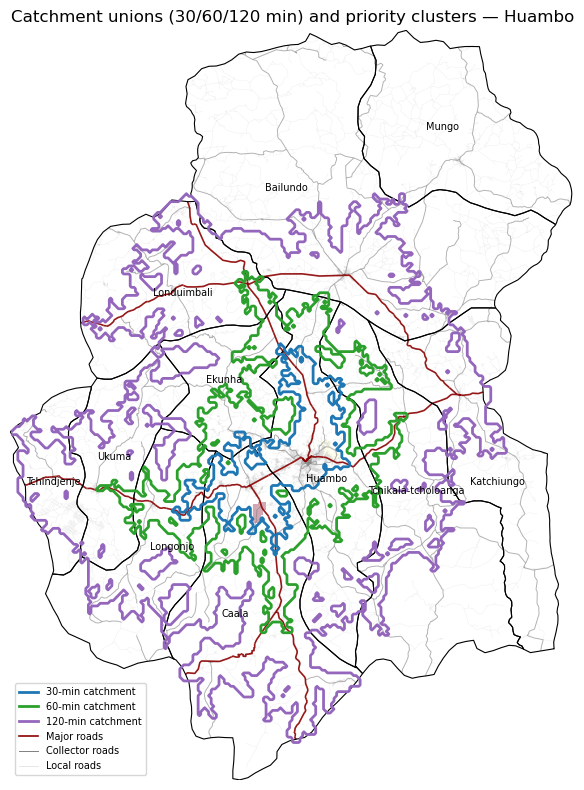

In [23]:
# Figure S3 — Catchment unions (30/60/120 min) and priority clusters
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
from pathlib import Path

from config import (
    PATHS,
    AOI,
    out_r,
    CATCHMENTS_KPI_CSV,
    PRIORITY_CLUSTERS_TIF,
)


def make_figure_s3(
    top_k_sites: int = 3,
    thresholds: tuple[int, ...] = (30, 60, 120),
    outfile: Path | None = None,
):
    """
    Build Figure S3 for the current AOI:

    - Selects top_k_sites by population within 60 min (from catchments_kpis.csv)
    - For each threshold in `thresholds`, builds the UNION of those sites'
      catchments from {AOI}_catch_site{N}_{thresh}min.tif
    - Plots:
        * priority clusters (Step 11 raster),
        * union catchment outlines at each threshold,
        * ADM2 boundaries + labels,
        * roads classified as Major / Collector / Local.
    """
    # ------------------------------------------------------------------
    # 1) Read catchment KPIs and pick top sites by 60-min population
    # ------------------------------------------------------------------
    csv_path = CATCHMENTS_KPI_CSV
    if not Path(csv_path).exists():
        raise FileNotFoundError(f"Catchment KPI table not found: {csv_path}")

    kpis = pd.read_csv(csv_path)
    required = {"thresh_min", "pop", "site_index"}
    if not required.issubset(kpis.columns):
        raise ValueError(f"{csv_path} missing required columns {required}")

    k60 = kpis[kpis["thresh_min"] == 60].copy()
    if k60.empty:
        raise ValueError(f"No rows for thresh_min=60 in {csv_path}")

    k60 = k60.sort_values("pop", ascending=False).reset_index(drop=True)
    top_sites = list(k60["site_index"].head(top_k_sites).astype(int))
    print(f"AOI={AOI} | Using top {len(top_sites)} sites by 60-min population: {top_sites}")

    # ------------------------------------------------------------------
    # 2) Priority clusters background (Step 11 raster)
    # ------------------------------------------------------------------
    if not Path(PRIORITY_CLUSTERS_TIF).exists():
        raise FileNotFoundError(f"Priority clusters raster not found: {PRIORITY_CLUSTERS_TIF}")
    clusters = rxr.open_rasterio(PRIORITY_CLUSTERS_TIF, masked=True).squeeze()

    template_da = None
    union_masks: dict[int, np.ndarray] = {}

    # ------------------------------------------------------------------
    # 3) Build union catchment masks for each threshold
    # ------------------------------------------------------------------
    for t in thresholds:
        union = None
        for sid in top_sites:
            tif = out_r(f"catch_site{int(sid)}_{t}min")
            if not Path(tif).exists():
                continue
            da = rxr.open_rasterio(tif, masked=True).squeeze()
            if template_da is None:
                template_da = da
            mask = (da.values > 0)
            union = mask if union is None else (union | mask)

        if union is not None:
            union_masks[t] = union

    if not union_masks:
        raise RuntimeError(
            "No union catchment masks could be built. "
            "Check that catch_site*_Xmin.tif exists in outputs/rasters."
        )

    # ------------------------------------------------------------------
    # 4) Base vectors: ADM2 + roads (classified)
    # ------------------------------------------------------------------
    adm2 = gpd.read_file(PATHS.BND_ADM2)
    roads = gpd.read_file(PATHS.ROADS)

    major_classes = {
        "motorway", "motorway_link",
        "trunk", "trunk_link",
        "primary", "primary_link",
    }
    collector_classes = {
        "secondary", "secondary_link",
        "tertiary", "tertiary_link",
    }

    def classify_road(row):
        fc = str(row.get("fclass", "")).lower()
        if fc in major_classes:
            return "Major"
        elif fc in collector_classes:
            return "Collector"
        else:
            # Local roads = everything else
            return "Local"

    roads["road_class"] = roads.apply(classify_road, axis=1)
    roads_major = roads[roads["road_class"] == "Major"]
    roads_collector = roads[roads["road_class"] == "Collector"]
    roads_local = roads[roads["road_class"] == "Local"]

    # ------------------------------------------------------------------
    # 5) Plot
    # ------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 8))

    # Background: priority clusters
    clusters.plot(
        ax=ax,
        cmap="YlOrRd",
        alpha=0.35,
        add_colorbar=False,
    )

    # Roads
    roads_local.plot(ax=ax, linewidth=0.4, alpha=0.3, color="lightgrey")
    roads_collector.plot(ax=ax, linewidth=0.7, alpha=0.6, color="grey")
    roads_major.plot(ax=ax, linewidth=1.2, alpha=0.9, color="darkred")

    # ADM2 boundaries + labels
    adm2.boundary.plot(ax=ax, linewidth=0.8, color="black")
    if "NAM_2" in adm2.columns:
        for _, row in adm2.iterrows():
            if row.geometry is None or row.geometry.is_empty:
                continue
            x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
            ax.text(x, y, str(row["NAM_2"]), fontsize=7, ha="center", va="center")

    # Catchment contours on top
    if template_da is None:
        template_da = clusters

    colors_by_t = {
        30: "tab:blue",
        60: "tab:green",
        120: "tab:purple",
    }

    for t in thresholds:
        mask = union_masks.get(t)
        if mask is None:
            continue

        # IMPORTANT: keep 0 outside, 1 inside → contour at 0.5
        mask_float = mask.astype("float32")  # 1 inside, 0 outside

        da_t = template_da.copy()
        da_t.values = mask_float

        da_t.plot.contour(
            ax=ax,
            levels=[0.5],
            colors=colors_by_t.get(t, "black"),
            linewidths=2.0,      # thicker so it stands out
            linestyles="solid",
            add_colorbar=False,
        )

    ax.set_title(f"Catchment unions (30/60/120 min) and priority clusters — {AOI.capitalize()}")
    ax.set_axis_off()

    # Legend
    from matplotlib.lines import Line2D
    threshold_lines = [
        Line2D([0], [0],
               color=colors_by_t.get(t, "black"),
               lw=2.0,
               label=f"{t}-min catchment")
        for t in thresholds if t in union_masks
    ]
    road_lines = [
        Line2D([0], [0], color="darkred", lw=1.2, label="Major roads"),
        Line2D([0], [0], color="grey", lw=0.7, label="Collector roads"),
        Line2D([0], [0], color="lightgrey", lw=0.4, label="Local roads"),
    ]
    handles = threshold_lines + road_lines
    ax.legend(handles=handles, loc="lower left", fontsize=7, frameon=True)

    fig.tight_layout()

    if outfile is None:
        outfile = PATHS.OUT_F / f"{AOI}_fig_s3_catchments_union.png"
    outfile = Path(outfile)
    outfile.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(outfile, dpi=300, bbox_inches="tight")
    print("Saved figure to:", outfile)

    plt.show()
    return fig, ax


# Run for current AOI (e.g. Huambo)
fig_s3, ax_s3 = make_figure_s3(top_k_sites=3, thresholds=(30, 60, 120))
